이 ipynb 파일은 dense crf를 시각화해주는 파일입니다.
이 파일에서 사용자가 직접 입력해줘야 되는 부분은
### **'0) 경로 환경설정'**
### **'2) Dense-CRF 함수 정의'에서의 변수(POS_XY_STD, POS_W, Bi_XY_STD, Bi_RGB_STD, Bi_W)**
입니다.

In [1]:
import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import json
from collections import namedtuple

from importlib import import_module

import numpy as np
import matplotlib.pyplot as plt

import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils

import skimage.io as io

import pandas as pd
from matplotlib.patches import Patch
import webcolors
import cv2

import copy

import random

### **0) 경로 환경설정**

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_path = "/opt/ml/segmentation/input/data/"
json_path = "/opt/ml/segmentation/semantic-segmentation-level2-cv-13/inference_config.json"

### **1) 카테고리별 mask 색과 legend 표시를 위한 함수 정의**

In [3]:
class_colormap = pd.read_csv("/opt/ml/segmentation/baseline_code/class_dict.csv")
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

# variable for legend
category_and_rgb = [[category, (r,g,b)] for _, (category, r, g, b) in enumerate(class_colormap.values)]
legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                            edgecolor=webcolors.rgb_to_hex(rgb), 
                            label=category) for category, rgb in category_and_rgb]

def collate_fn(batch):
    return tuple(zip(*batch))

### **2) Dense-CRF 함수 정의**

In [26]:
MAX_ITER = 10

############## cmk
POS_XY_STD = 1
POS_W = 1

Bi_XY_STD = 15
Bi_RGB_STD = 13
Bi_W = 1
##############

################# jdj
# POS_XY_STD = 3 
# POS_W = 3 
# Bi_XY_STD = 80              
# Bi_RGB_STD = 13
# Bi_W = 10 
#################

def dense_crf(img, output_probs):
    c = output_probs.shape[0]
    h = output_probs.shape[1]
    w = output_probs.shape[2]

    U = utils.unary_from_softmax(output_probs)
    U = np.ascontiguousarray(U)

    img = np.ascontiguousarray(img)

    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=POS_XY_STD, compat=POS_W) 
    d.addPairwiseBilateral(sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=img, compat=Bi_W) 
    
    Q = d.inference(MAX_ITER)
    Q = np.array(Q).reshape((c, h, w))
    return Q 

### **3) Model, Augmentation, DataLoader 불러오기**

In [27]:
with open(json_path, 'r') as f:
    cfgs = json.load(f, object_hook=lambda d: namedtuple('x', d.keys())(*d.values()))
    
model_module = getattr(import_module("model"), cfgs.model.name)
model = model_module(**cfgs.model.args._asdict())
checkpoint = torch.load(cfgs.weight_path, map_location=device)
state_dict = checkpoint['net']
model.load_state_dict(state_dict)
model = model.to(device) 
model.eval()

test_augmentation_module = getattr(import_module("augmentation"), cfgs.augmentation)
test_augmentation = test_augmentation_module().transform
test_dataset_module = getattr(import_module("dataset"), cfgs.dataset)
test_dataset = test_dataset_module(data_root = cfgs.data_root, json_dir = cfgs.json_path, transform=test_augmentation)
test_loader = DataLoader(dataset=test_dataset, **cfgs.dataloader.args._asdict(), collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### **4) Dense-CRF 시각화**

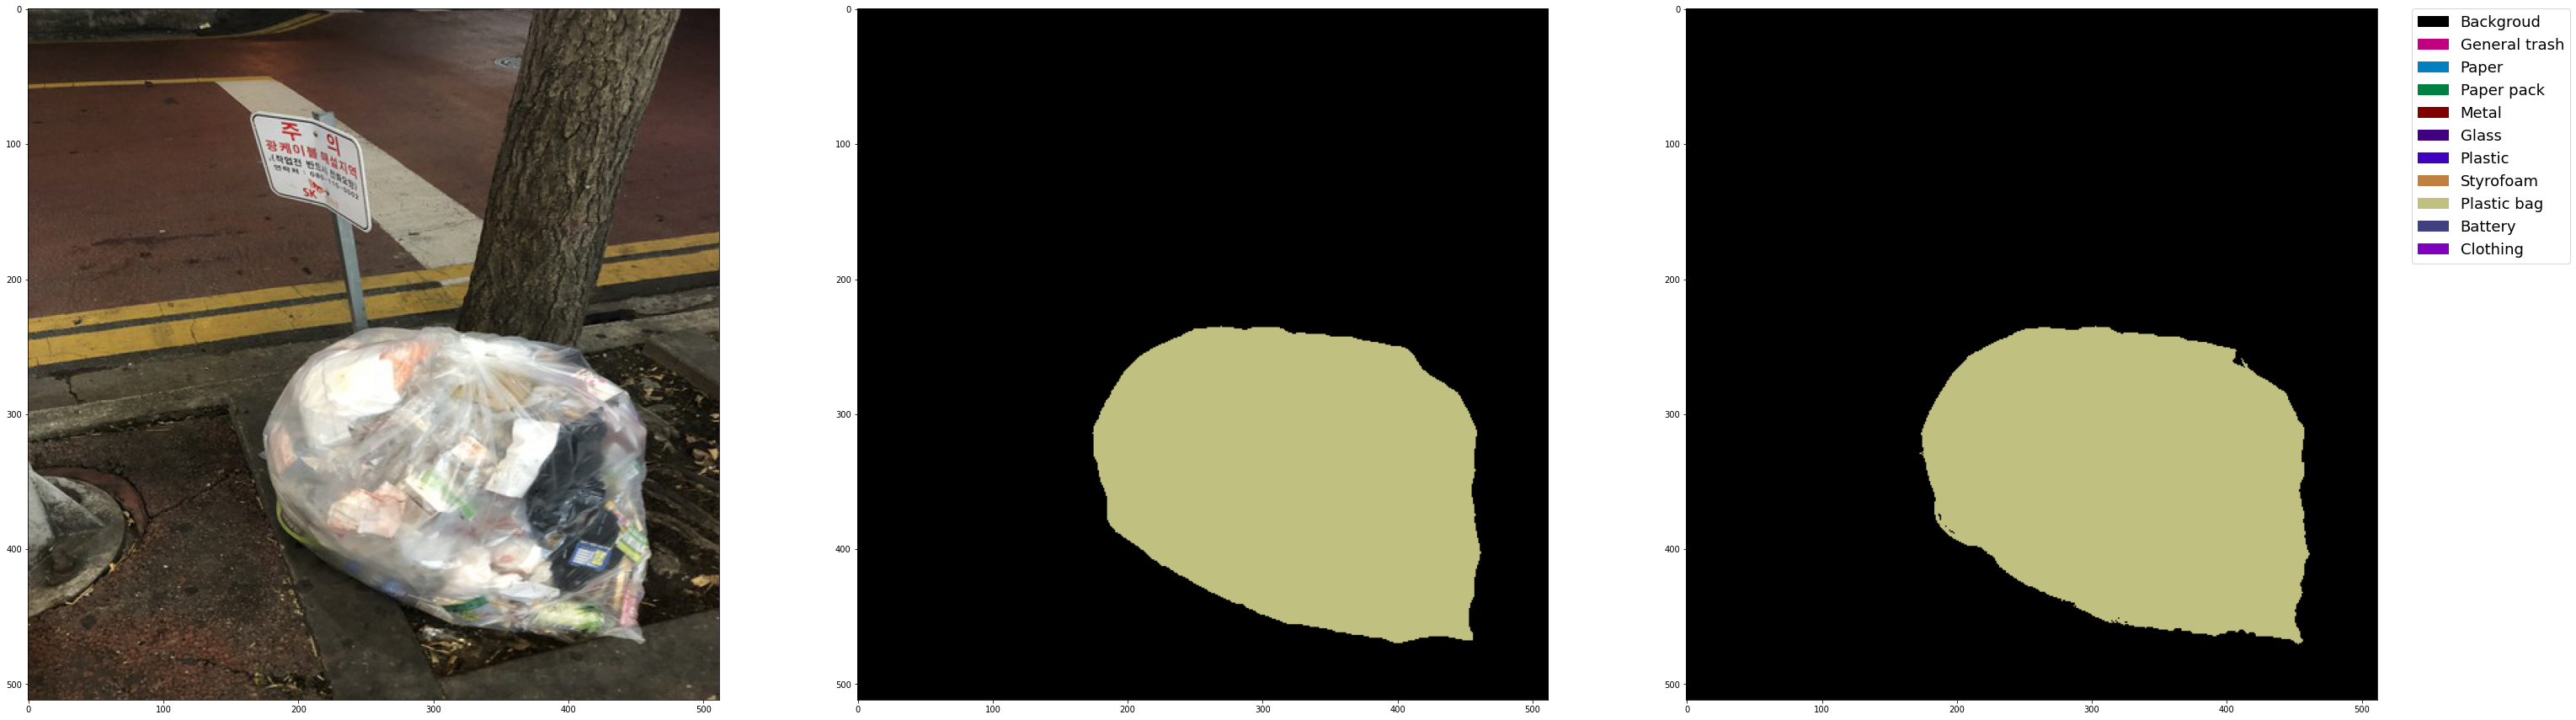

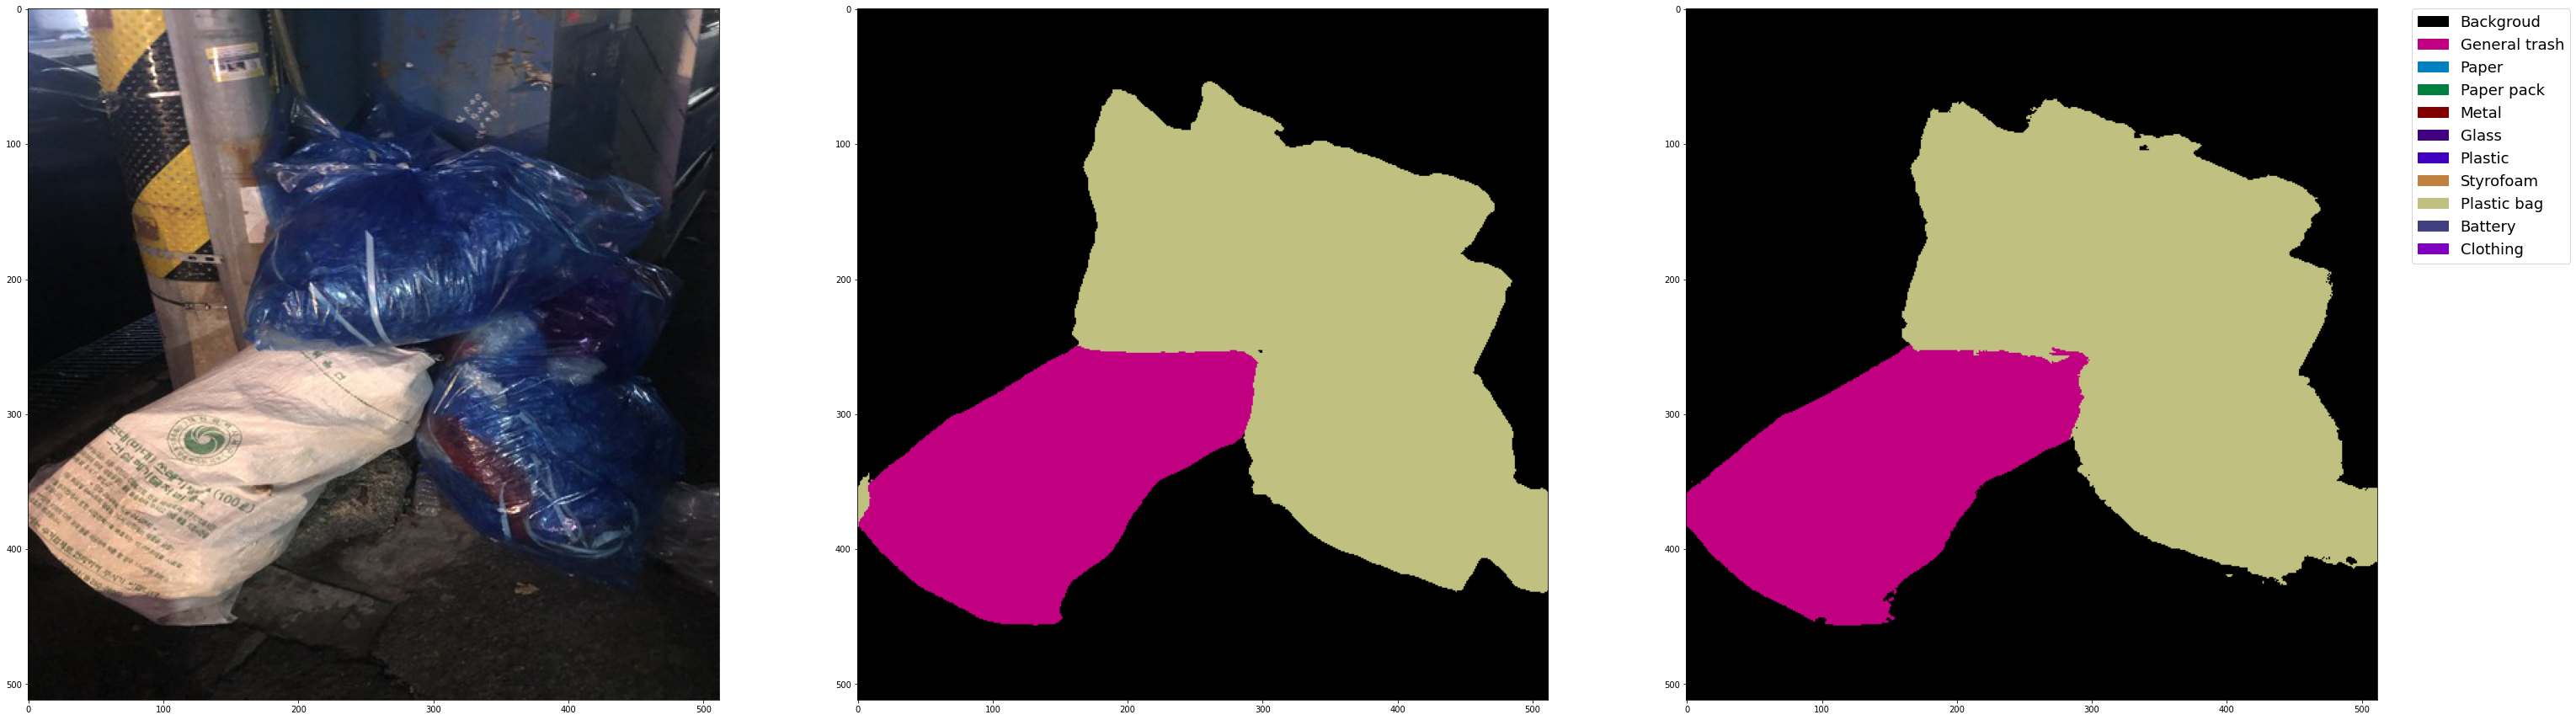

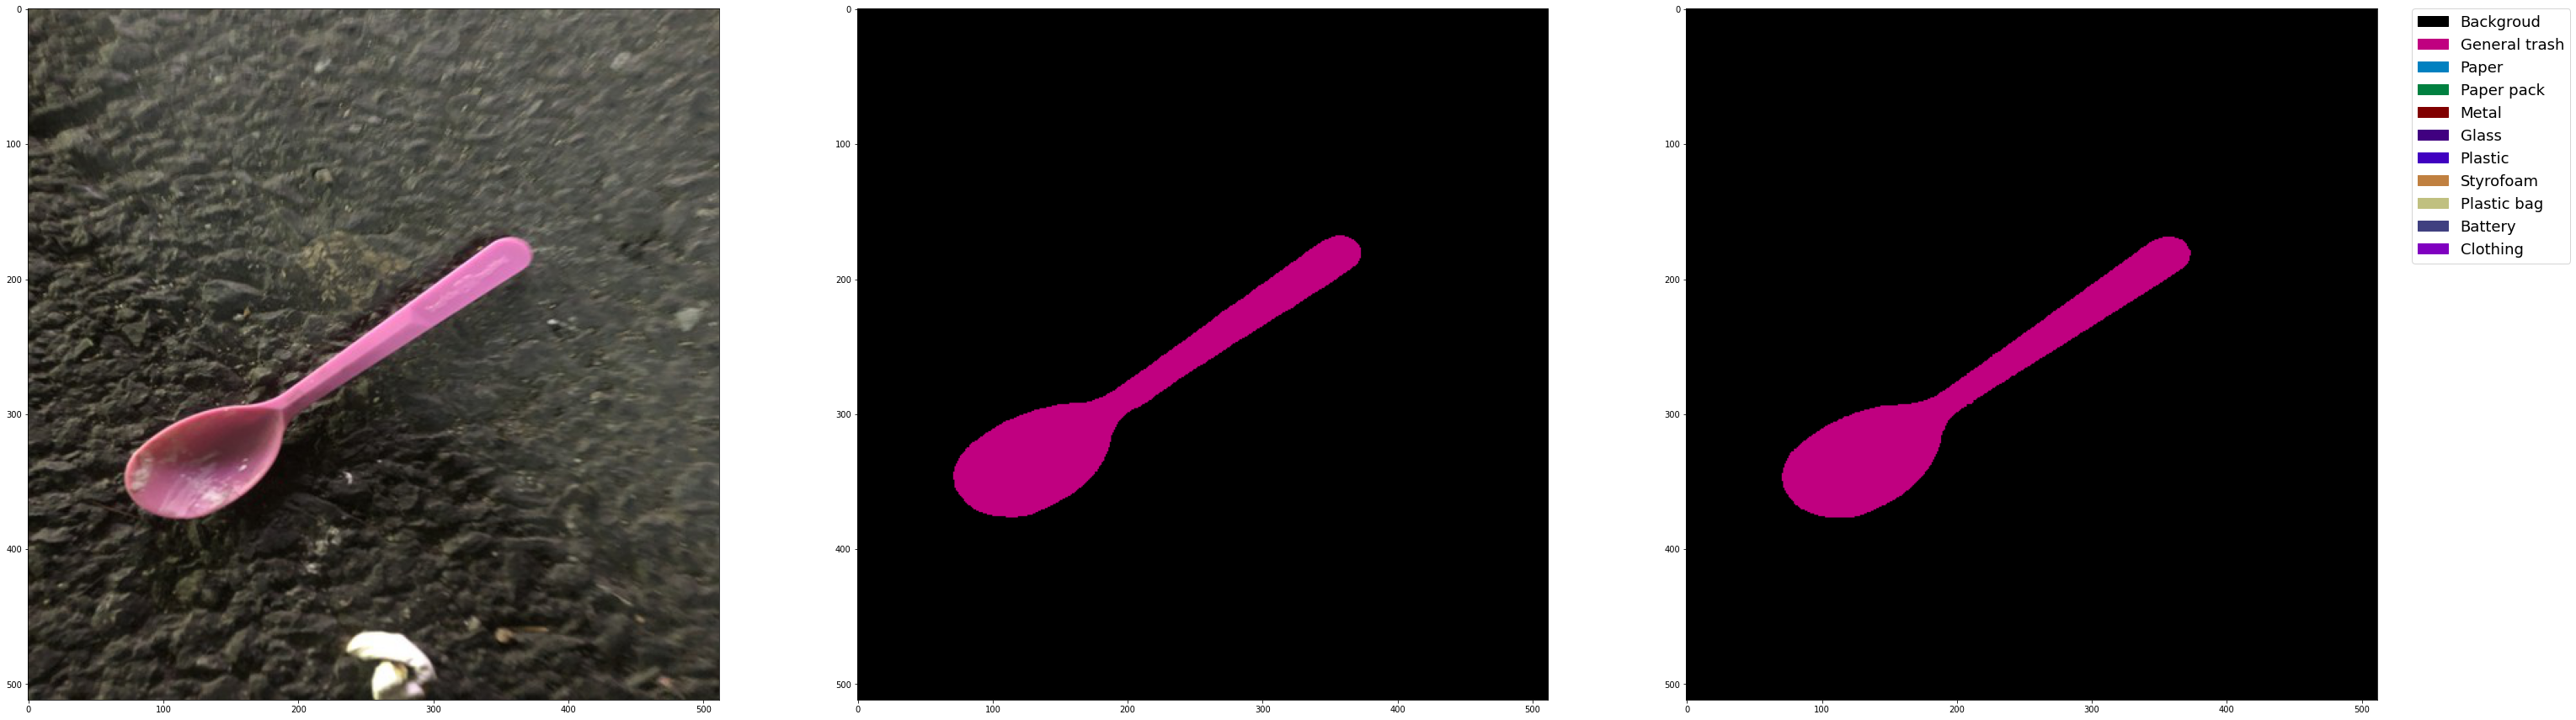

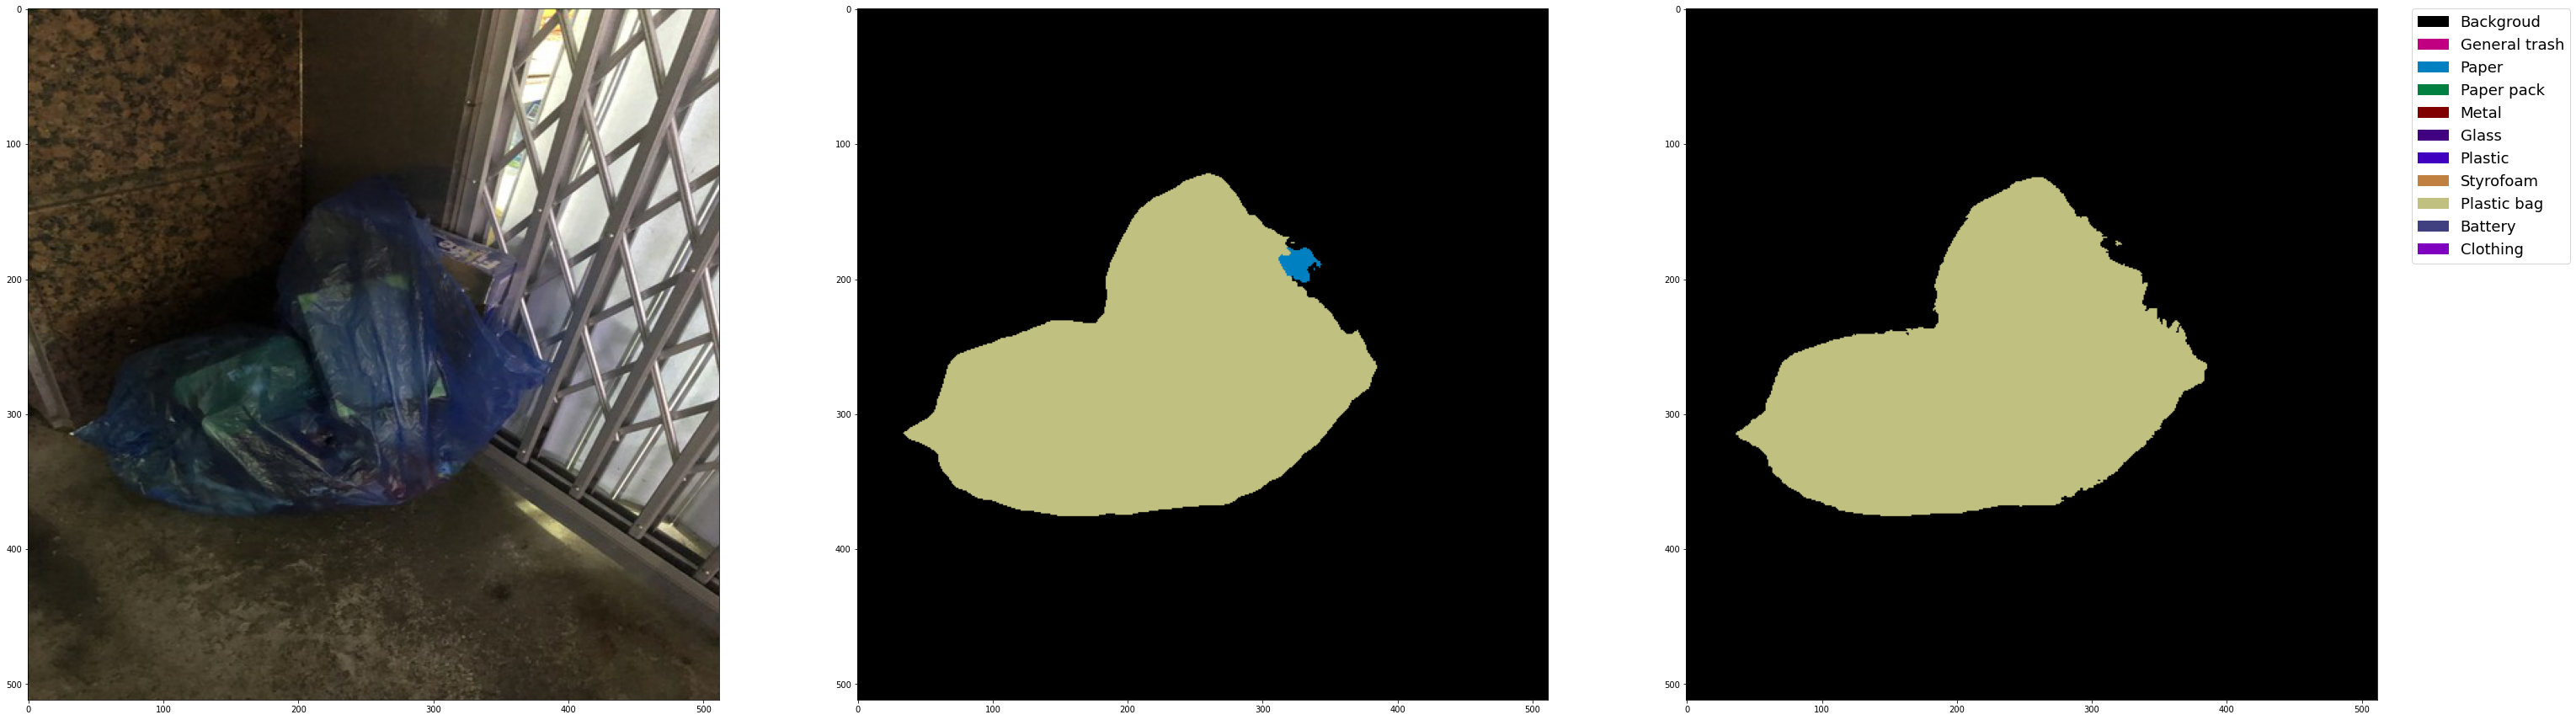

In [28]:
loader_iter = iter(test_loader)
for i, ele in enumerate(loader_iter):
    if i == 0:
        imgs, img_infos = ele
        outs = model(torch.stack(imgs).to(device))['out']

        for idx in range(0, min(4, len(imgs))):
            with torch.no_grad():
                img = io.imread(data_path + img_infos[idx]['file_name'])
                out_crf = dense_crf(img, outs[idx].detach().cpu().numpy())

                oms_ori = torch.argmax(outs[idx].squeeze(), dim=0).detach().cpu().numpy()
                oms_crf = np.argmax(out_crf.squeeze(), axis=0)

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(50, 50))
            ax1.imshow(img)
            ax2.imshow(label_to_color_image(oms_ori))
            ax3.imshow(label_to_color_image(oms_crf))
            ax3.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, prop={'size': 18})
            plt.show()